# Sentiment Analysis with LSTM (imdb)

- This tutorial shows how to build a deep learning classifier for binary sentiment classification. 
- We will demonstrate three alternatives of dealing with the textual data:
    - Building a sequence model using self-trained embedding layer
    - Building a sequence model using pre-trained embeddings (GloVe)

In [1]:
import numpy as np
import tensorflow
from tensorflow import keras
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import pandas as pd

## Loading Data

In [2]:
imdb = pd.read_csv('../../../RepositoryData/data/kaggle-IMDB-dataset/IMDB-Dataset.csv')

In [3]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(imdb, test_size = 0.5, random_state=123)

In [5]:
## check train/test data
print(train_data.shape)
print(test_data.shape)

(25000, 2)
(25000, 2)


In [6]:
## check class distribution for train/test
print(train_data.sentiment.value_counts())
print(test_data.sentiment.value_counts())

positive    12574
negative    12426
Name: sentiment, dtype: int64
negative    12574
positive    12426
Name: sentiment, dtype: int64


## Cleaning Data

- Usually in deep learning NLP, we don't have to spend a lot of time preprocessing/cleaning the textual data. 
- The main concerns are often related to removal of irrelevant tokens or normalizing the texts (in casing, contractions, etc.)
- Because in this tutorial, we are going to demonstrate the use of pre-trained word embeddings. In other words, we need to map each word token to the pre-trained word embedding matrix. 
- If we have the same tokenization as the pre-trained model, we can reduce the percentage of unknown words.

In [7]:
import TAWP
import re
from TAWP.contractions import CONTRACTION_MAP

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    ## create a regex pattern of all contracted forms
    contractions_pattern = re.compile('({})'.format('|'.join(
        contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)  # the whole matched contraction

        # if the matched contraction (=keys) exists in the dict,
        # get its corresponding uncontracted form (=values)
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())

        return expanded_contraction

    # find each contraction in the pattern,
    # find it from text,
    # and replace it using the output of
    # expand_match
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [8]:
def normalize(text):
    text = expand_contractions(text)
    text = re.sub(r'<.+?>',"", text)
    text = re.sub(r'\s+',' ', text)
    return text
    
normalize_corpus = np.vectorize(normalize)

## X and y

In [9]:
%%time
X_train = normalize_corpus([X for (X,y) in zip(train_data.review, train_data.sentiment)])
# y_train = np.array([1 if y in ['positive'] else 0 for (X,y) in zip(train_data.review, train_data.sentiment)])

X_test = normalize_corpus([X for (X,y) in zip(test_data.review, test_data.sentiment)])
# y_test = np.array([1 if y in ['positive'] else 0 for (X,y) in zip(test_data.review, test_data.sentiment)])

CPU times: user 1min 44s, sys: 1.36 s, total: 1min 45s
Wall time: 1min 45s


In [10]:
y_train = np.array([1 if y in ['positive'] else 0 for (X,y) in zip(train_data.review, train_data.sentiment)])
y_test = np.array([1 if y in ['positive'] else 0 for (X,y) in zip(test_data.review, test_data.sentiment)])
# y_train = np.array([y for (X,y) in zip(train_data.review, train_data.sentiment)])
# y_test = np.array([y for (X,y) in zip(test_data.review, test_data.sentiment)])

In [11]:
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

1    12574
0    12426
dtype: int64
0    12574
1    12426
dtype: int64


In [12]:
X_train[:2]

array(['This is a great show, and will make you cry, this group people really loved each other in real life and it shows time and time again. Email me and let us chat. I have been to Australia and they real do talk like this.I want you to enjoy Five Mile Creek and pass on these great stories of right and wrong, and friendship to your kids. I have all 40 Episodes on DVD-R that I have collected over the last 5 years. See my Five Mile Creek tribute at www.mikeandvicki.com and hear the extended theme music. let us talk about them.These people are so cool!',
       'This film was really different from what I had imagined but exceeded my expectations nevertheless. This film has the exactly right mixture of comedy, drama, political criticism and satire (not necessarily in that order). Without being patronizing or wisenheimer it reveals the open and subtle problems of our capitalist democratic high technology society. It makes you laugh instantly and remain in thought afterwards. For those of 

In [13]:
y_train[:2]

array([1, 1])

## Text to Sequences

### Tokenizer

In [14]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words= NUM_WORDS, lower=True)
tokenizer.fit_on_texts(X_train)

### Vocabulary

In [15]:
VOCAB_SIZE = tokenizer.num_words+1
print(VOCAB_SIZE)

10001


### Word Index

In [16]:
w2id = tokenizer.word_index
id2w = {id:w for (w,id) in w2id.items()}

In [17]:
list(w2id.items())[:10]

[('the', 1),
 ('and', 2),
 ('a', 3),
 ('of', 4),
 ('is', 5),
 ('to', 6),
 ('it', 7),
 ('in', 8),
 ('i', 9),
 ('this', 10)]

In [18]:
list(id2w.items())[:10]

[(1, 'the'),
 (2, 'and'),
 (3, 'a'),
 (4, 'of'),
 (5, 'is'),
 (6, 'to'),
 (7, 'it'),
 (8, 'in'),
 (9, 'i'),
 (10, 'this')]

### Text to Sequences

In [19]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

### Check Text Lengths Distribution

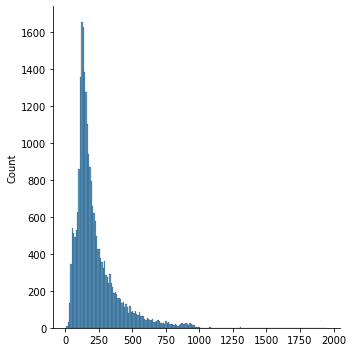

In [20]:
X_train_len = [len(text) for text in X_train_seq]
import seaborn as sns
sns.displot(X_train_len)

### Padding/Truncating

In [21]:
MAX_LEN = 250

In [22]:
X_train_seq_pad = sequence.pad_sequences(X_train_seq, maxlen = MAX_LEN, truncating='pre', padding='pre' )
X_train_seq_pad.shape

(25000, 250)

In [23]:
X_test_seq_pad = sequence.pad_sequences(X_test_seq, maxlen = MAX_LEN, truncating='pre', padding='pre' )
X_test_seq_pad.shape

(25000, 250)

In [24]:
# # Deep Learn with Python Version
# max_features = 10000 # vocab size
# max_len = 200 # text length to consider
# batch_size = 128

# (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_features)

In [25]:
# print(train_data[0]) # first train doc
# print(train_labels[0]) # first train label

In [26]:
# # check class
# print(type(train_data))
# print(type(train_labels))
# # check dtype
# print(train_data.dtype)
# print(train_labels.dtype)

# # check shape
# print(train_data.shape)
# print(test_data.shape)

In [27]:
# ## vectorize labels
# y_train = np.asarray(train_labels).astype('float32')
# y_test = np.asarray(test_labels).astype('float32')
# print(type(y_train))
# print(y_train.dtype)

## Padding Text Length

In [28]:
# ## Padding Texts Lengths
# train_data = sequence.pad_sequences(train_data, maxlen=max_len)
# test_data = sequence.pad_sequences(test_data, maxlen=max_len)
# print(train_data.shape)
# print(test_data.shape)

## Loading Pre-trained Embeddings from Spacy

- For `spacy` language models, not all the versions provide the word vectors as part of the language model package.
- For English language models, the medium and large language models come with the word vectors.
- We extract the spacy word embedding matrix and map the words in our current corpus vocabulary to get the word vectors.
- It is possible that words in our vocabulary do not have a match in spacy language model.

In [29]:
%%time
# Use the N-dimensional word vectors trained on the Common Crawl using the GloVe model
# Provided by spaCy (lg = 300 dimensions)

import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'tag','entity'])

CPU times: user 2.63 s, sys: 974 ms, total: 3.6 s
Wall time: 1min 34s


In [30]:
## initialize word embedding matrix
EMBED_DIM = 300
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
embedding_matrix.shape

(10001, 300)

In [31]:
unk_cnt = 0
unk_set = set()
len(w2id)

83309

In [32]:
spacy_w2v = {}
spacy_w2v = {nlp.vocab.strings[wid]:wvec for (wid, wvec) in nlp.vocab.vectors.items()}

In [33]:
spacy_w2v['the'][:10]

array([ 0.27204  , -0.06203  , -0.1884   ,  0.023225 , -0.018158 ,
        0.0067192, -0.13877  ,  0.17708  ,  0.17709  ,  2.5882   ],
      dtype=float32)

In [34]:
nlp('the').vector[:10]

array([ 0.27204  , -0.06203  , -0.1884   ,  0.023225 , -0.018158 ,
        0.0067192, -0.13877  ,  0.17708  ,  0.17709  ,  2.5882   ],
      dtype=float32)

In [35]:
print(spacy_w2v.get('次'))

None


In [36]:
w2id['the']

1

In [37]:
%%time
unk_cnt = 0
unk_set = set()

for word in list(w2id.keys())[:10000]:
    cur_word_vec = spacy_w2v.get(word)
    
    if cur_word_vec is not None:
        cur_word_id = w2id[word]
        embedding_matrix[cur_word_id]=cur_word_vec

    else:
        unk_cnt +=1
        unk_set.add(word)
print("Total Unkown Words in IMDB:", unk_cnt)

Total Unkown Words in IMDB: 38
CPU times: user 24.9 ms, sys: 1.56 ms, total: 26.5 ms
Wall time: 25.2 ms


In [38]:
print(unk_set)

{'bergmans', 'lubitsch', 'argentos', 'lumet', 'northfork', 'otoole', 'sydow', 'milland', 'preminger', 'ustinov', 'altmans', 'lupino', 'austens', 'keatons', 'fulcis', 'widmark', 'spielbergs', 'hitchcocks', 'harron', 'bernsen', 'branaghs', 'matthau', 'naschy', 'ratso', 'it´s', '\x97', 'mattei', 'eastwoods', 'dudikoff', 'wynorski', 'sirk', 'gielgud', 'atwill', 'mclaglen', 'gwtw', 'blondell', 'seagals', 'rosemarys'}


In [39]:
del spacy_w2v

## Loading Pre-trained GloVe Embeddings 

- Download the GloVe pre-trained embeddings from its [official website](https://nlp.stanford.edu/projects/glove/)
- Unzip the file and use the version you are interested.
- They differ in terms of the number of embedding dimensions.

## Model Defining

In [40]:
## Model Building

from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D, Input, Bidirectional, LSTM

LSTM_DIM = 64 # total LSTM units

In [41]:
def build_model_lstm():
    model = Sequential()
#     model.add(Input(shape=(MAX_LEN,)))
    model.add(Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation="sigmoid"))
    return model
def build_model_lstm_pretrained_emb(train_emb=False):
    model = Sequential()
#     model.add(Input(shape=(MAX_LEN,)))

    model.add(Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True,
                        weights=[embedding_matrix], trainable=train_emb))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation="sigmoid"))
    return model

def build_model_bilstm_pretrain_emb(train_emb=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True, 
                       weights=[embedding_matrix], trainable=train_emb))
    model.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=True, dropout=0.5)))
    model.add(Bidirectional(LSTM(LSTM_DIM, dropout=0.25)))
    model.add(Dense(1, activation="sigmoid"))
    return model

In [42]:
model1 = build_model_lstm()

In [44]:
model2_1 = build_model_lstm_pretrained_emb(train_emb=False)
model2_2 = build_model_lstm_pretrained_emb(train_emb=True)
model3_1 = build_model_bilstm_pretrain_emb(train_emb=False)
model3_2 = build_model_bilstm_pretrain_emb(train_emb=True)

In [45]:
model1.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy", "Precision", "Recall"])

In [46]:
model2_1.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy", "Precision", "Recall"])
model2_2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy", "Precision", "Recall"])

In [47]:
model3_1.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy", "Precision", "Recall"])
model3_2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy", "Precision", "Recall"])

In [48]:
model2_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,093,805
Trainable params: 93,505
Non-trainable params: 3,000,300
_________________________________________________________________


## Model Fitting

In [49]:
EPOCH= 10
BATCH_SIZE = 256

In [50]:
## Model fitting
history1 = model1.fit(X_train_seq_pad, y_train,
                   epochs=EPOCH,
                   batch_size= BATCH_SIZE,
                   validation_split=0.2)

# Comment out to skip

Epoch 1/10
79/79 [==============================] - 89s 1s/step - loss: 0.5891 - accuracy: 0.6652 - precision: 0.6797 - recall: 0.5965 - val_loss: 0.3201 - val_accuracy: 0.8696 - val_precision: 0.8798 - val_recall: 0.8582
Epoch 2/10
79/79 [==============================] - 79s 1s/step - loss: 0.2407 - accuracy: 0.9071 - precision: 0.9099 - recall: 0.9054 - val_loss: 0.3272 - val_accuracy: 0.8688 - val_precision: 0.8282 - val_recall: 0.9329
Epoch 3/10
79/79 [==============================] - 77s 980ms/step - loss: 0.1729 - accuracy: 0.9391 - precision: 0.9360 - recall: 0.9434 - val_loss: 0.3755 - val_accuracy: 0.8604 - val_precision: 0.8067 - val_recall: 0.9503
Epoch 4/10
79/79 [==============================] - 78s 981ms/step - loss: 0.1314 - accuracy: 0.9531 - precision: 0.9487 - recall: 0.9588 - val_loss: 0.3883 - val_accuracy: 0.8624 - val_precision: 0.9055 - val_recall: 0.8113
Epoch 5/10
79/79 [==============================] - 77s 969ms/step - loss: 0.0973 - accuracy: 0.9690 - pre

In [51]:
## Model fitting
history2_1 = model2_1.fit(X_train_seq_pad, y_train,
                   epochs=EPOCH,
                   batch_size= BATCH_SIZE,
                   validation_split=0.2)

# Comment out to skip

Epoch 1/10
79/79 [==============================] - 63s 756ms/step - loss: 0.6273 - accuracy: 0.6275 - precision: 0.6289 - recall: 0.6402 - val_loss: 0.4815 - val_accuracy: 0.7852 - val_precision: 0.8613 - val_recall: 0.6834
Epoch 2/10
79/79 [==============================] - 59s 749ms/step - loss: 0.4640 - accuracy: 0.7882 - precision: 0.8053 - recall: 0.7588 - val_loss: 0.4126 - val_accuracy: 0.8226 - val_precision: 0.7964 - val_recall: 0.8701
Epoch 3/10
79/79 [==============================] - 60s 761ms/step - loss: 0.4186 - accuracy: 0.8139 - precision: 0.8106 - recall: 0.8263 - val_loss: 0.4275 - val_accuracy: 0.8290 - val_precision: 0.8324 - val_recall: 0.8268
Epoch 4/10
79/79 [==============================] - 62s 781ms/step - loss: 0.3907 - accuracy: 0.8287 - precision: 0.8351 - recall: 0.8229 - val_loss: 0.3448 - val_accuracy: 0.8502 - val_precision: 0.8461 - val_recall: 0.8586
Epoch 5/10
79/79 [==============================] - 60s 763ms/step - loss: 0.3513 - accuracy: 0.8499

In [52]:
history3_1 = model3_1.fit(X_train_seq_pad, y_train,
                   epochs=EPOCH,
                   batch_size= BATCH_SIZE,
                   validation_split=0.2)

Epoch 1/10
79/79 [==============================] - 178s 2s/step - loss: 0.5951 - accuracy: 0.6543 - precision: 0.6592 - recall: 0.6480 - val_loss: 0.4429 - val_accuracy: 0.8008 - val_precision: 0.7555 - val_recall: 0.8935
Epoch 2/10
79/79 [==============================] - 158s 2s/step - loss: 0.4037 - accuracy: 0.8161 - precision: 0.8113 - recall: 0.8258 - val_loss: 0.3704 - val_accuracy: 0.8474 - val_precision: 0.8486 - val_recall: 0.8482
Epoch 3/10
79/79 [==============================] - 166s 2s/step - loss: 0.3923 - accuracy: 0.8210 - precision: 0.8176 - recall: 0.8292 - val_loss: 0.4165 - val_accuracy: 0.8106 - val_precision: 0.7929 - val_recall: 0.8443
Epoch 4/10
79/79 [==============================] - 159s 2s/step - loss: 0.3724 - accuracy: 0.8366 - precision: 0.8322 - recall: 0.8425 - val_loss: 0.3814 - val_accuracy: 0.8280 - val_precision: 0.8940 - val_recall: 0.7469
Epoch 5/10
79/79 [==============================] - 157s 2s/step - loss: 0.3656 - accuracy: 0.8411 - precisi

## Model Evaluation

In [53]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
# Plotting results
def plot1(history):

    matplotlib.rcParams['figure.dpi'] = 100
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

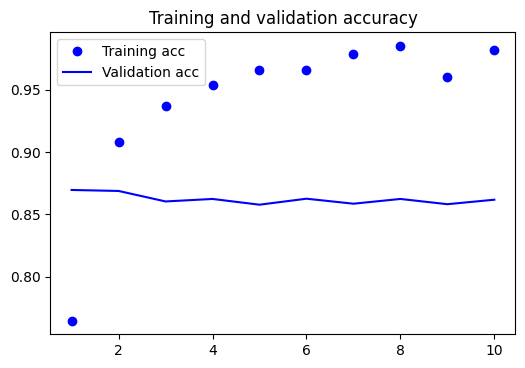

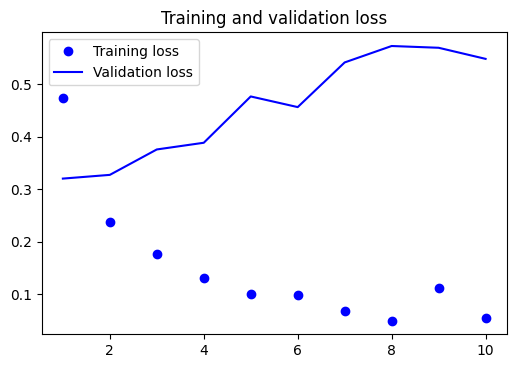

In [55]:
plot1(history1)

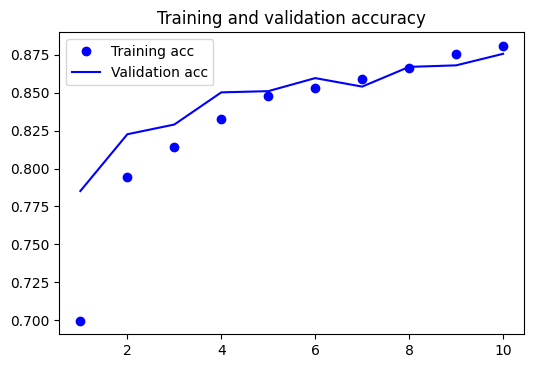

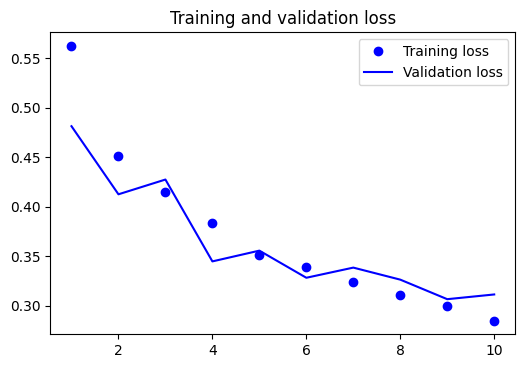

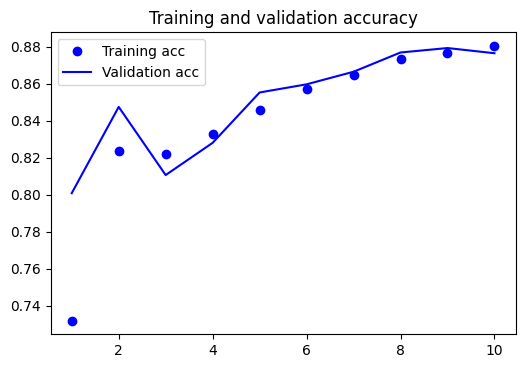

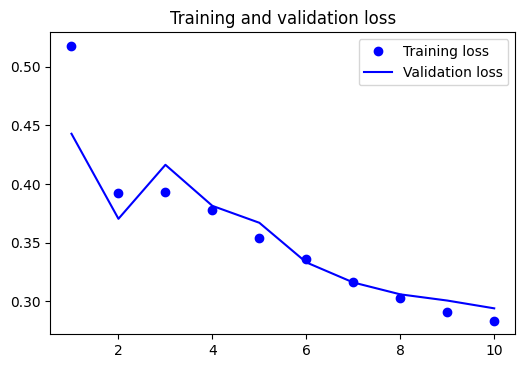

In [57]:
plot1(history2_1)
plot1(history3_1)

## Model Saving

In [58]:
# # model.save('../data/sent-analysis-lstm-v1.h5')
# import keras
# model = keras.models.load_model('../data/sent-analysis-lstm-v1.h5')

## Model Prediction

In [59]:
# y_pred = model3_1.predict_classes(X_test_seq_pad)

In [60]:
## Prediction and model performance
y_pred = (model3_1.predict(X_test_seq_pad) > 0.5).astype("int32")


In [61]:
y_pred[:10]

array([[0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

In [62]:
# functions from Text Analytics with Python book
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=level_labels)) 
    print(cm_frame) 
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)
from sklearn import metrics
import pandas as pd

In [63]:
display_model_performance_metrics(y_test, y_pred.flatten(), classes=[0,1])

Model Performance metrics:
------------------------------
Accuracy: 0.8859
Precision: 0.8874
Recall: 0.8859
F1 Score: 0.8858

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.91      0.86      0.88     12574
           1       0.86      0.92      0.89     12426

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   0      1
Actual: 0      10762   1812
        1       1040  11386
